In [19]:
# Standard Librarys
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import pickle

# Other Ml stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Facebook Model
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

# Google Model
import tensorflow as tf
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, TimeDistributed, GRU

# Bayesian optimazation
from skopt import gp_minimize

np.random.seed(32)
set_random_seed(32)

# Global Functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true )) * 100

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/ourownstory/neural_prophet/master/example_data/air_passengers.csv')
data['ds'] = pd.to_datetime(data['ds'], infer_datetime_format=True)
treino = data.loc[data['ds'].dt.year <= 1958, 'y']
teste = data.loc[data['ds'].dt.year >= 1959, 'y']

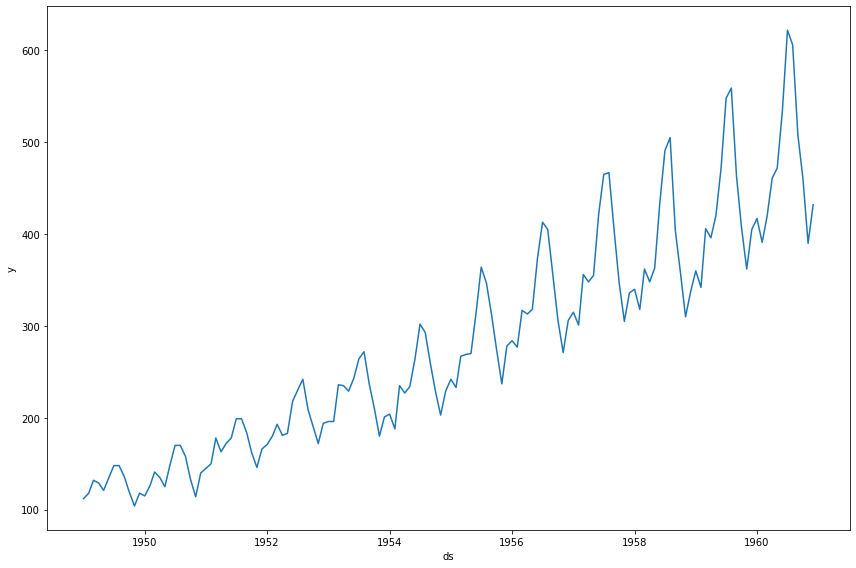

In [3]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='ds', y='y', data=data)
plt.tight_layout()

In [38]:
def otimizar_modelo(params):
    ''' 
    Testes realizados:
    n_changepoints = params[3],
    loss_func = params[4]  (str("MSE"), str("Huber"))

    Batch_size = params[4]
    error -> ValueError: batch_size should be a positive integer value, but got batch_size=9

    #normalize = params[4]
    #('minmax', 'standardize', 'soft', 'off'), # Data Normalization
    '''

    learning_rate = params[0]
    num_hidden_layers = params[1]
    d_hidden = params[2]
    changepoints_range = params[3]
    seasonality_mode = params[4]
    
    
    print(f'\n {params}')

    model = NeuralProphet(
        # Model Training:
        learning_rate = learning_rate,
        loss_func="Huber",                  #loss_func
        epochs=20,
        batch_size = 8,                     # 8
        # Model Depth
        num_hidden_layers=num_hidden_layers,# Doc= 1-2!
        d_hidden=d_hidden,                  # Dimension of hidden layers of AR-Net
        # Data PreProcesing:
        impute_missing=True,
        normalize="auto",                   # Type of normalization ('minmax', 'standardize', 'soft', 'off') # "auto"
        # Trend Related:
        n_changepoints=5,                   # Set a number where the trend rate may change   # 5
        trend_reg=0,                        # Seting a value > 0, = regularized trend rate!, important for automaticaly detect relevant change points
        trend_reg_threshold=False,
        changepoints_range=changepoints_range,# Control the range of the training data used to fit the trend! #0.9
        # Seasonality Related:
        yearly_seasonality="auto",          # Are only consider if it have at least 2(lags) of information  # "auto"
        weekly_seasonality="auto",          # For each parameter, example: Yearly Seasonality only will be
        daily_seasonality="auto",           # Consider if 2 years of data is avalibe, by default 'auto', or False to deactivate!
        seasonality_mode=seasonality_mode,  # Additive or Multiplicative, depending on the trend! (Multiplicative)        # "multiplicative", 
        # Other Parameters:
        
        growth="linear",                    # Determine trend types: 'linear', 'discontinuous', 'off'
        changepoints=None,                  # list of dates that may include change points (None -> automatic )
        seasonality_reg=0,
        n_forecasts=1,
        n_lags=0,
        ar_sparsity=None,                   # Sparcity in the AR coefficients
        log_level=None,                     # Determines the logging level of the logger object
    )
    
    metricas = model.fit(
        data, freq='M', validate_each_epoch=True, 
        valid_p=0.2                         #, plot_live_loss=True  # only with NeuralProphet     
        )

    validacao = model.make_future_dataframe(
                                    data,
                                    periods=12, 
                                    n_historic_predictions=len(data)
                                )

    forecast = model.predict(validacao)
    x = metricas[-1:].to_records()
    
    return float(x['MAE'])

space = [
    (1e-3, 1e-1, 'log-uniform'),      # Learning Rate
    (1, 3),                           # N_hiddenLayers
    (3, 5),                           # Dimension of hidden layers
    (0.2, 0.8),                       # changepoints_range
    ("Additive", "Multiplicative"),
]

resultados_gp = gp_minimize(otimizar_modelo, space, random_state=1, verbose=1, n_calls=5, n_random_starts=2)

In [15]:
def plot_forecast(model, data, periods, historic_pred=True, highlight_steps_ahead=None):
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast)
    else:    
        model.plot(forecast)

with open('neuralprophet_model.pkl', "wb") as f:
    pickle.dump(m, f)

[0.08120152439569885, 1, 4, 0.6953361428325305]

Text(0.5, 1.0, 'Mean Temperature in Delhi')

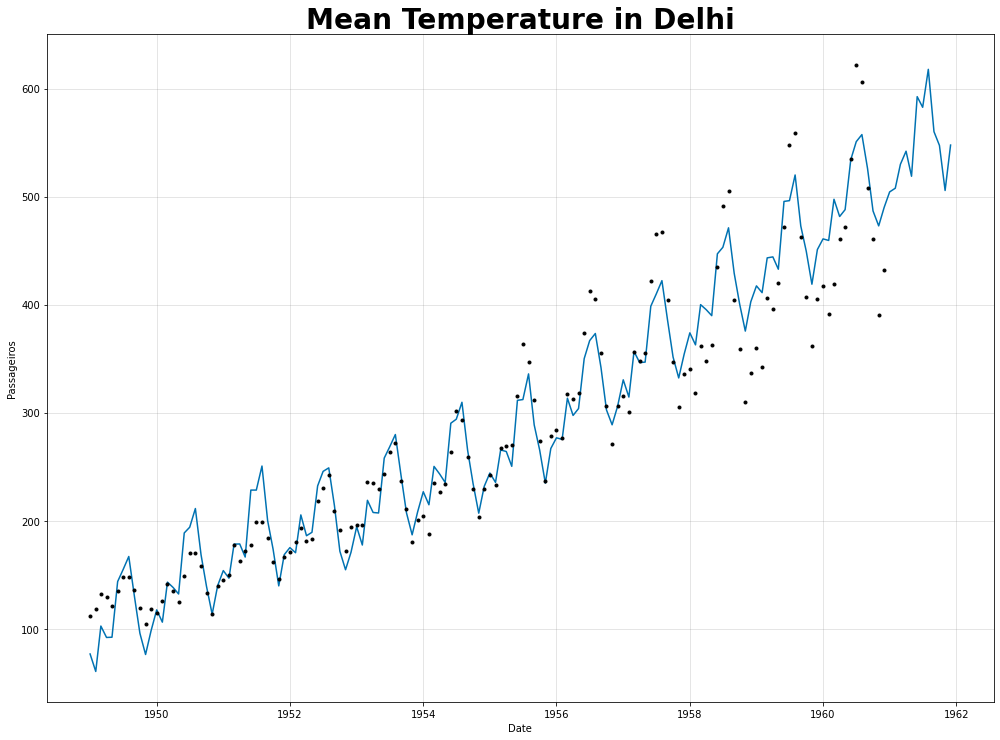

In [20]:
fig, ax = plt.subplots(figsize=(14, 10)) 
model.plot(forecast, xlabel="Date", ylabel="Passageiros", ax=ax)
ax.set_title("Mean Temperature in Delhi", fontsize=28, fontweight="bold")
# model.plot_parameters()

#fig, ax = plt.subplots(figsize=(14, 10))
#ax.plot(metricas["MAE"], 'ob', linewidth=6, label="Training Loss")  
#ax.plot(metricas["MAE_val"], '-r', linewidth=2, label="Validation Loss")
# You can use metrics["SmoothL1Loss"] and metrics["SmoothL1Loss_val"]

In [7]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


X, y = split_sequence(treino, 12)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [22]:
## TensorFlow approach!!!
# 1 Model: LSTM 


lstm = Sequential()
lstm.add(LSTM(64, activation='relu', input_shape=(12,1)))
lstm.add(Dense(10))
lstm.add(Dropout(0.3))
lstm.add(Dense(1))

lstm.compile(optimizer = 'adam', loss = 'mae', )
lstm.fit(X, y, validation_data=(X[-24:], y[-24:]),
    shuffle=False, batch_size=8, epochs=50)

preds = lstm.predict(X[-24:])
print(f'The MAPE of LSTM 1 model is {round(mean_absolute_percentage_error(y[-24:], preds), 2)}%')
print(f'The MAE of LSTM 1 model is {mean_absolute_error(y[-24:], preds)}')

Epoch 1/50
14/14 [==============================] - 1s 20ms/step - loss: 157.9270 - val_loss: 135.4175
Epoch 2/50
14/14 [==============================] - 0s 7ms/step - loss: 73.4978 - val_loss: 50.2768
Epoch 3/50
14/14 [==============================] - 0s 7ms/step - loss: 63.5349 - val_loss: 40.3055
Epoch 4/50
14/14 [==============================] - 0s 7ms/step - loss: 56.2225 - val_loss: 48.8368
Epoch 5/50
14/14 [==============================] - 0s 7ms/step - loss: 48.8390 - val_loss: 61.5832
Epoch 6/50
14/14 [==============================] - 0s 7ms/step - loss: 58.4394 - val_loss: 39.4597
Epoch 7/50
14/14 [==============================] - 0s 6ms/step - loss: 47.8231 - val_loss: 34.4158
Epoch 8/50
14/14 [==============================] - 0s 7ms/step - loss: 46.3328 - val_loss: 33.8974
Epoch 9/50
14/14 [==============================] - 0s 7ms/step - loss: 45.8922 - val_loss: 33.2769
Epoch 10/50
14/14 [==============================] - 0s 7ms/step - loss: 49.1666 - val_loss: 38.5

In [15]:
# 2 Model Deep LSTM
lstm = Sequential()
lstm.add(LSTM(64, activation='relu', input_shape=(12,1)))
lstm.add(Dense(50)) # activation='relu' #kernel_constraint=maxnorm(3)
lstm.add(Dropout(0.3))
lstm.add(Dense(50))
lstm.add(Dropout(0.4))
lstm.add(Dense(1))

lstm.compile(optimizer = 'adam', loss = 'mae', )
#lstm.fit(X, y, shuffle=False, batch_size=8, epochs=20)
lstm.fit(X, y, #validation_data=(X[-24:], y[-24:]),
    shuffle=False, batch_size=12, epochs=50)

preds = lstm.predict(X[-24:])
print(f'The MAPE of LSTM 2 model is {round(mean_absolute_percentage_error(y[-24:], preds), 2)}%')
print(f'The MAE of LSTM 2 model is {mean_absolute_error(y[-24:], preds)}')

Epoch 1/50
9/9 [==============================] - 1s 3ms/step - loss: 166.7952
Epoch 2/50
9/9 [==============================] - 0s 4ms/step - loss: 70.5976
Epoch 3/50
9/9 [==============================] - 0s 3ms/step - loss: 65.4685
Epoch 4/50
9/9 [==============================] - 0s 3ms/step - loss: 59.5948
Epoch 5/50
9/9 [==============================] - 0s 3ms/step - loss: 51.5394
Epoch 6/50
9/9 [==============================] - 0s 3ms/step - loss: 53.3391
Epoch 7/50
9/9 [==============================] - 0s 3ms/step - loss: 72.7725
Epoch 8/50
9/9 [==============================] - 0s 3ms/step - loss: 48.6116
Epoch 9/50
9/9 [==============================] - 0s 3ms/step - loss: 59.3954
Epoch 10/50
9/9 [==============================] - 0s 4ms/step - loss: 55.8641
Epoch 11/50
9/9 [==============================] - 0s 4ms/step - loss: 53.2355
Epoch 12/50
9/9 [==============================] - 0s 3ms/step - loss: 48.1126
Epoch 13/50
9/9 [==============================] - 0s 3ms/st

In [52]:
def otimizar_lstm(parametros):

    drop_out_rate = parametros[0]
    weight_constraint = parametros[1]
    neurons_input_layer = parametros[2]
    neuros_hidden_layers = parametros[3]
    batch_size = parametros[4]
    
    print(f'Drop_out_rate: {parametros[0]}, weight_constraint: {parametros[1]}, neurons_input_layer: {parametros[2]}, neuros_hidden_layers: {parametros[3]}, batch_size: {parametros[4]} ')
    
    lstm_model = Sequential()
    # Input layer
    lstm_model.add(LSTM(neurons_input_layer, activation='relu', 
                   kernel_initializer = tf.keras.initializers.he_uniform, 
                   kernel_constraint = max_norm(weight_constraint),
                   input_shape=(12,1)))
    # Hidden Layers
    lstm_model.add(Dropout(drop_out_rate))
    lstm_model.add(Dense(neuros_hidden_layers))
    lstm_model.add(Dropout(drop_out_rate))
    lstm_model.add(Dense(neuros_hidden_layers))
    # Output Layer
    lstm_model.add(Dense(1))

    lstm_model.compile(
        loss = 'mae',
        optimizer = 'Adam',
        # Metrics['mae']
    )

    lstm_model.fit(X[:-12], y[:-12], shuffle=False,  
                   batch_size=batch_size, epochs=25)
    
    preds = lstm_model.predict(X[-12:])
    print( f'MAPE: {mean_absolute_percentage_error(y[-12:], preds)}')
    return mean_absolute_error(y[-12:], preds)

space = [
    (0.2, 0.4),                  # drop_out_rate
    (1, 3),                        # weight_constraint
    (64, 128),                        # neurons_input_layer
    (32, 64),                         # neuros_hidden_layers
    (8, 12),                      # batch_size
]

In [53]:
resultados_lstm = gp_minimize(otimizar_lstm, space, random_state=1, verbose=1, n_calls=15, n_random_starts=5)

- 0s 3ms/step - loss: 76.8126
Epoch 23/25
8/8 [==============================] - 0s 3ms/step - loss: 79.9755
Epoch 24/25
8/8 [==============================] - 0s 3ms/step - loss: 92.6257
Epoch 25/25
8/8 [==============================] - 0s 3ms/step - loss: 82.6371
MAPE: 15.807460630059575
Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 1.9681
Function value obtained: 64.5916
Current minimum: 44.8785
Iteration No: 10 started. Searching for the next optimal point.
Drop_out_rate: 0.4, weight_constraint: 2, neurons_input_layer: 64, neuros_hidden_layers: 64, batch_size: 11 
Epoch 1/25
9/9 [==============================] - 1s 4ms/step - loss: 336.9328
Epoch 2/25
9/9 [==============================] - 0s 3ms/step - loss: 289.1315
Epoch 3/25
9/9 [==============================] - 0s 4ms/step - loss: 213.3261
Epoch 4/25
9/9 [==============================] - 0s 4ms/step - loss: 211.8128
Epoch 5/25
9/9 [==============================] - 0s 4ms/step - loss: 170.9

In [54]:
resultados_lstm.x # MAPE: 14.485442825224506 # Mae: 30.29

[0.4, 2, 64, 64, 11]

In [ ]:
# Gans Aproach